# Configuration

In [1]:
import scipy
!pip3 install --upgrade scipy
from scipy import stats
from scipy.stats import bernoulli, binom
import statsmodels.api as sm
import statistics
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
import math
import pylab
from statsmodels import graphics
from statsmodels.graphics import gofplots as gp
import seaborn as sns
from numpy import random
from scipy.stats import rankdata
import random as rd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import sys
sys.path.append('/content/drive/MyDrive/Colab\ Notebooks/CSDS313/Final')
sys.path.append('/content/drive/MyDrive/Colab\ Notebooks/CSDS313/Final/ml-100k')
import numpy.linalg as ln

# Experiment 1

In [22]:
def incrementalSVD(mat_a1, mat_a2, k, only_uk=False):
  """Apply SVD for a matrix with new columns

  :param mat_a1: original matrix (m x n1)
  :param mat_a2: new columns (m x n2)
  :param k: rank-k for the approximated result
  :returns: rank-k approximated U, S, V^T as a result of svd([mat_a1, mat_a2])
  """

  if mat_a1.shape[0] != mat_a2.shape[0]:
    raise ValueError('Error: the number of rows both in mat_a1 and mat_a2 should be the same')

  # get the number of rows and columns
  m = mat_a1.shape[0]
  n1 = mat_a1.shape[1]
  n2 = mat_a2.shape[1]

  if k < 1:
    raise ValueError('Error: rank k must be greater than or equal to 1')
  if k > min(m, n1 + n2):
    raise ValueError('Error: rank k must be less than or equal to min(m, n1 + n2)')

  # apply SVD for the original matrix
  mat_u1, vec_s1, mat_v1t = ln.svd(mat_a1, full_matrices=False)
  mat_s1 = np.diag(vec_s1)

  # define mat_f as [S, U^T A_1], and decompose it by SVD
  mat_f = np.hstack((mat_s1, np.dot(mat_u1.T, mat_a2)))
  mat_uf, vec_sf, mat_vft = ln.svd(mat_f, full_matrices=False)

  # keep rank-k approximation
  mat_uf = mat_uf[:, :k]
  if only_uk: return  np.dot(mat_u1, mat_uf)
  vec_sf = vec_sf[:k]
  mat_vft = mat_vft[:k, :]

  # create a temporary matrix to compute V_k
  V = mat_v1t.T
  Z1 = np.zeros((n1, n2))
  Z2 = np.zeros((n2, V.shape[1]))
  I = np.eye(n2)
  mat_tmp = np.vstack((
      np.hstack((V, Z1)),
      np.hstack((Z2, I))
    ))
  mat_vk = np.dot(mat_tmp, mat_vft.T)

  # compute U_k and S_k
  mat_uk = np.dot(mat_u1, mat_uf)
  mat_sk = np.diag(vec_sf)

  return mat_uk, mat_sk, mat_vk.T

In [20]:
def incrementalApproSVD(mat_b1, mat_b2, c1, c2, k, p1, p2):
  """Apply Incremental ApproSVD for a matrix with new columns

  :param mat_b1: original matrix (m x n1)
  :param mat_b2: new columns (m x n2)
  :param c1: the number of sampled columns from B1
  :param c2: the number of sampled columns from B2
  :param k: rank-k for the approximated result
  :param p1: sampling probabilities for each column in B1
  :param p2: sampling probabilities for each column in B2
  :returns: H_k as an output of Incremental ApproSVD (H_k H_k^T = I)
  """

  if mat_b1.shape[0] != mat_b2.shape[0]:
    raise ValueError('Error: the number of rows both in mat_a1 and mat_a2 should be the same')

  if len(p1[p1<0]) != 0:
    raise ValueError('Error: negative probabilities in p1 are not allowed')
  if len(p2[p2<0]) != 0:
    raise ValueError('Error: negative probabilities in p2 are not allowed')

  if not np.isclose(sum(p1), 1.):
    raise ValueError('Error: sum of the probabilities must be 1 for p1')
  if not np.isclose(sum(p2), 1.):
    raise ValueError('Error: sum of the probabilities must be 1 for p2')

  # get the number of rows and columns
  m = mat_b1.shape[0]
  n1 = mat_b1.shape[1]
  n2 = mat_b2.shape[1]

  if c1 >= n1:
    raise ValueError('Error: c1 must be less than n1')
  if c2 >= n2:
    raise ValueError('Error: c2 must be less than n2')

  if k < 1:
    raise ValueError('Error: rank k must be greater than or equal to 1')
  if k > min(m, c1 + c2):
    raise ValueError('Error: rank k must be less than or equal to min(m, n1 + n2)')

  # sample c1 columns from B1, and combine them as a matrix C1
  mat_c1 = np.zeros((m, c1))
  samples = np.random.choice(range(n1), c1, replace=False, p=p1)
  for t in range(c1):
    mat_c1[:, t] = mat_b1[:, samples[t]] / np.sqrt(c1 * p1[samples[t]])

  # sample c2 columns from B2, and combine them as a matrix C2
  mat_c2 = np.zeros((m, c2))
  samples = np.random.choice(range(n2), c2, replace=False, p=p2)
  for t in range(c2):
    mat_c2[:, t] = mat_b2[:, samples[t]] / np.sqrt(c2 * p2[samples[t]])

  # apply Incremental SVD for smaller matrices C1, C2, and get only U_k as H_k
  return incrementalSVD(mat_c1, mat_c2, k, True)

In [8]:
from sklearn.model_selection import KFold
import numpy as np

In [28]:
def createRatingPairs(ratings_test, mat1, mat2, n1, n2):
  rating_pairs = []
  for r in ratings_test:
    if r[1] >= (n1 + n2): continue
    r1 = mat1[r[0]-1, r[1]-1]
    r2 = mat2[r[0]-1, r[1]-1]
    rating_pairs.append((r1, r2))
  return np.asarray(rating_pairs)

def computeMAE(rating_pairs):
  n = rating_pairs.shape[0]
  total = 0
  for rt, rp in rating_pairs:
    total += abs(rt - rp)
  return total / float(n)

def computeRMSE(rating_pairs):
  n = rating_pairs.shape[0]
  total = 0
  for rt, rp in rating_pairs:
    total += (rt - rp) ** 2
  return np.sqrt(total / float(n))

def ratings2matrix(ratings):
  data = np.zeros((n_users, n_movies))
  for r in ratings:
    data[r[0]-1, r[1]-1] = r[2] # data[user_idx, movie_idx] = rating
  return data

In [9]:
PATH = '/content/drive/MyDrive/Colab Notebooks/CSDS313/Final/ml-100k/u.data'
n_users = 943
n_movies = 1682
n_ratings = 100000

ratings = []
with open(PATH) as f:
  for i in range(n_ratings):
    line = f.readline()
    ratings.append(list(map(int, line.rstrip().split('\t'))))
ratings = np.asarray(ratings)

In [10]:
def ratings2matrix(ratings):
  data = np.zeros((n_users, n_movies))
  for r in ratings:
    data[r[0]-1, r[1]-1] = r[2] # data[user_idx, movie_idx] = rating
  return data

In [11]:
# reduced rank
k = 10

# number of original columns for Incremental ApproSVD
# B1: 900, B2: 100
n1 = 900
n2 = 100

# how many columns are evaluated? (n_movies=1682 is the maximum)
# A1: 500, A2: 50
c1 = 500
c2 = 50

np.random.shuffle(ratings)
kf = KFold(n_splits=5)

iSVD_totalRMSE = 0.
ApproSVD_totalRMSE = 0.

In [12]:
def experiment(k,n1,n2,c1,c2):
  np.random.shuffle(ratings)
  kf = KFold(n_splits=5)

  iSVD_totalRMSE = 0.
  ApproSVD_totalRMSE = 0.
  for train_indices, test_indices in kf.split(ratings):

      # separate ratings to train and test
      ratings_train = ratings[train_indices]
      ratings_test = ratings[test_indices]

      # create training matrix
      mat_train = ratings2matrix(ratings_train)

      # rank-k approximation of [B1, B2] based on Incremental ApproSVD
      mat_b1 = mat_train[:, :n1]
      mat_b2 = mat_train[:, n1:n1+n2]

      # colums sampling probabilities for B1
      nnz_b1 = np.count_nonzero(mat_b1)
      p1 = np.zeros(n1)
      for i in range(n1):
        p1[i] = np.count_nonzero(mat_b1[:, i]) / float(nnz_b1)

      # colums sampling probabilities for B2
      nnz_b2 = np.count_nonzero(mat_b2)
      p2 = np.zeros(n2)
      for i in range(n2):
        p2[i] = np.count_nonzero(mat_b2[:, i]) / float(nnz_b2)

      mat_hk = incrementalApproSVD(mat_b1, mat_b2, c1, c2, k, p1, p2)
      mat_orig = mat_train[:, :n1+n2]
      mat_ApproSVD = np.dot(np.dot(mat_hk, mat_hk.T), mat_orig)

      # best rank-k approximation of [B1, B2] based on truncated SVD
      mat_u, vec_s, mat_vt = ln.svd(mat_train[:, :n1+n2], full_matrices=False)
      mat_SVD = np.dot(np.dot(mat_u[:, :k], np.diag(vec_s[:k])), mat_vt[:k, :])

      # compute RMSE between SVD and ApproSVD
      rating_pairs = createRatingPairs(ratings_test, mat_SVD, mat_ApproSVD, n1, n2)
      ApproSVD_totalRMSE += computeRMSE(rating_pairs)

      # rank-k approximation of [A1, A2] based on Incremental SVD
      mat_a1 = mat_train[:, :c1]
      mat_a2 = mat_train[:, c1:c1+c2]

      mat_u, mat_s, mat_vt = incrementalSVD(mat_a1, mat_a2, k)
      mat_iSVD = np.dot(np.dot(mat_u, mat_s), mat_vt)

      # best rank-k approximation of [A1, A2] based on truncated SVD
      mat_u, vec_s, mat_vt = ln.svd(mat_train[:, :c1+c2], full_matrices=False)
      mat_SVD = np.dot(np.dot(mat_u[:, :k], np.diag(vec_s[:k])), mat_vt[:k, :])

      # compute RMSE between SVD and iSVD
      rating_pairs = createRatingPairs(ratings_test, mat_SVD, mat_iSVD, c1, c2)
      iSVD_totalRMSE += computeRMSE(rating_pairs)

  return iSVD_totalRMSE, ApproSVD_totalRMSE

In [13]:
print ('Incremental SVD      vs. truncated SVD:', iSVD_totalRMSE / 5.)
print ('Incremental ApproSVD vs. truncated SVD:', ApproSVD_totalRMSE / 5.)

Incremental SVD      vs. truncated SVD: 0.0
Incremental ApproSVD vs. truncated SVD: 0.0


In [29]:
# conduct the experiment for 10 times
exp1 = []
for i in range(0,10):
  exp1.append(experiment(k,n1,n2,c1,c2))
print(exp1)

[(0.14950391796376555, 1.2828474741458225), (0.28919437093272155, 1.2404376151842795), (0.16192898447682155, 1.2791299481861014), (0.14891743666976404, 1.2372973223462154), (0.15533329322223005, 1.237464727870921), (0.1810598953669381, 1.183592489836391), (0.15191429579977514, 1.2125585603271005), (0.15200348050508022, 1.2681179127524782), (0.15749783313058646, 1.2241617828103273), (0.1488470904046614, 1.3040908004296294)]


In [30]:
exp1_df = pd.DataFrame(exp1)
print(exp1_df)

          0         1
0  0.149504  1.282847
1  0.289194  1.240438
2  0.161929  1.279130
3  0.148917  1.237297
4  0.155333  1.237465
5  0.181060  1.183592
6  0.151914  1.212559
7  0.152003  1.268118
8  0.157498  1.224162
9  0.148847  1.304091


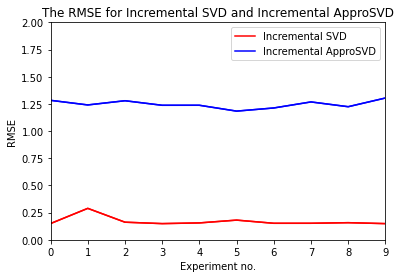

In [40]:
x=range(0,10)
y1=exp1_df[0]
y2=exp1_df[1]
plt.plot(x,y1,'r',x,y2,'b')
plt.plot(x,y1,'r',label='Incremental SVD')
plt.plot(x,y2,'b',label='Incremental ApproSVD')
plt.xlim((0,9))
plt.ylim((0,2))
plt.legend()
plt.title('The RMSE for Incremental SVD and Incremental ApproSVD')
plt.xlabel('Experiment no.')
plt.ylabel('RMSE')
plt.show()

# Experiment 2

Test the popularity bias before and after incrementalApproSVD

In [42]:
# calculate the appearance time and average rating for each item
df_ratings = pd.DataFrame(ratings)
df_ratings.columns = ['user','item','rating','time']
df_ratings.head(10)
appearance = df_ratings.groupby('item',as_index=False)['user'].count()
average = df_ratings.groupby('item', as_index=False)['rating'].mean()

In [43]:
mat_all = ratings2matrix(ratings)
mat_all_b1 = mat_all[:,:n1]
mat_all_b2 = mat_all[:,n1:n1+n2]

# colums sampling probabilities for B1
nnz_b1 = np.count_nonzero(mat_all_b1)
p1 = np.zeros(n1)
for i in range(n1):
  p1[i] = np.count_nonzero(mat_all_b1[:, i]) / float(nnz_b1)

# colums sampling probabilities for B2
nnz_b2 = np.count_nonzero(mat_all_b2)
p2 = np.zeros(n2)
for i in range(n2):
  p2[i] = np.count_nonzero(mat_all_b2[:, i]) / float(nnz_b2)

# calculate the approximation result for incremental Appro SVD
mat_hk = incrementalApproSVD(mat_all_b1, mat_all_b2, c1, c2, k, p1, p2)
mat_orig = mat_all[:, :n1+n2]
mat_ApproSVD = np.dot(np.dot(mat_hk, mat_hk.T), mat_orig)

# initialize the recommendation list
recommend_ApproSVD = np.zeros((n_users,10))
recommend_SVD = np.zeros((n_users,10))

In [44]:
# calculate the recommended items for all the users
for i in range(n_users):
  all_ratings = pd.DataFrame(columns=range(0,2))
  for j in range(0,n1+n2):
    if mat_all[i,j]!=0:
      all_ratings = all_ratings.append({0: mat_ApproSVD[i,j], 1: j},ignore_index=True) 
  all_ratings = all_ratings.sort_values(by=0,ascending=False)
  all_ratings[1] = all_ratings[1].astype(int)
  all_ratings = all_ratings.reset_index(drop=True)
  all_ratings = all_ratings.loc[0:9]
  recommend_ApproSVD[i,:] = all_ratings[1]

In [45]:
# calculate the approximation result for normal SVD
mat_u, vec_s, mat_vt = ln.svd(mat_all[:, :n1+n2], full_matrices=False)
mat_SVD = np.dot(np.dot(mat_u[:, :k], np.diag(vec_s[:k])), mat_vt[:k, :])

In [46]:
for i in range(n_users):
  all_ratings = pd.DataFrame(columns=range(0,2))
  for j in range(0,n1+n2):
    if mat_all[i,j]!=0:
      all_ratings = all_ratings.append({0: mat_SVD[i,j], 1: j},ignore_index=True) 
  all_ratings = all_ratings.sort_values(by=0,ascending=False)
  all_ratings[1] = all_ratings[1].astype(int)
  all_ratings = all_ratings.reset_index(drop=True)
  all_ratings = all_ratings.loc[0:9]
  recommend_SVD[i,:] = all_ratings[1]

In [47]:
print(recommend_ApproSVD)

[[ 49.  99. 167. ... 173.  88. 171.]
 [285. 257. 299. ... 274. 236. 293.]
 [301. 299. 257. ... 306. 339. 267.]
 ...
 [  0. 180. 116. ... 293.  14. 297.]
 [299. 312.  49. ... 268. 495. 356.]
 [ 55.  78.  95. ...  63.  10. 567.]]


In [48]:
print(recommend_SVD)

[[ 49.  99.  55. ...  88. 180. 171.]
 [285. 257. 299. ... 301. 236.  49.]
 [299. 301. 257. ... 293. 306. 267.]
 ...
 [180.   0. 256. ... 293. 474. 297.]
 [299. 312.  49. ... 317. 327. 171.]
 [ 55.  63.  21. ... 173.  68. 181.]]


In [49]:
# calculate the average number of ratings and the average average rating scores for the top 10 movies for each user

#intialize
user_average_SVD = np.zeros(n_users)
user_appearance_SVD = np.zeros(n_users)
user_average_ApproSVD = np.zeros(n_users)
user_appearance_ApproSVD = np.zeros(n_users)

for i in range(n_users):

  user_average_SVD[i]=0
  for j in range(10):
    user_average_SVD[i]+= average.loc[recommend_SVD[i,j]]['rating']
  user_average_SVD[i] = user_average_SVD[i]/10

  user_appearance_SVD[i]=0
  for j in range(10):
    user_appearance_SVD[i]+= appearance.loc[recommend_SVD[i,j]]['user']
  user_appearance_SVD[i] = user_appearance_SVD[i]/10

  user_average_ApproSVD[i]=0
  for j in range(10):
    user_average_ApproSVD[i]+= average.loc[recommend_ApproSVD[i,j]]['rating']
  user_average_ApproSVD[i] = user_average_ApproSVD[i]/10

  user_appearance_ApproSVD[i]=0
  for j in range(10):
    user_appearance_ApproSVD[i]+= appearance.loc[recommend_ApproSVD[i,j]]['user']
  user_appearance_ApproSVD[i] = user_appearance_ApproSVD[i]/10

In [50]:
# concat the average ratings for SVD and ApproSVD for comparation
df_average_SVD = pd.DataFrame( user_average_SVD, columns=['SVD'] )
df_average_ApproSVD = pd.DataFrame( user_average_ApproSVD, columns=['ApproSVD'] )
compare_average = pd.concat( [df_average_SVD, df_average_ApproSVD], axis=1 )
print(compare_average)

          SVD  ApproSVD
0    4.121549  4.121549
1    3.966204  3.846025
2    3.678246  3.721306
3    3.430349  3.541526
4    4.004848  3.984816
..        ...       ...
938  3.636474  3.514899
939  4.024903  4.020018
940  3.739623  3.729038
941  4.079862  4.031743
942  4.099960  4.077607

[943 rows x 2 columns]


In [51]:
df_appearance_SVD = pd.DataFrame( user_appearance_SVD, columns=['SVD'])
df_appearance_ApproSVD = pd.DataFrame( user_appearance_ApproSVD, columns=['ApproSVD'])
compare_appearance = pd.concat( [df_appearance_SVD, df_appearance_ApproSVD], axis=1 )
print(compare_appearance)

       SVD  ApproSVD
0    408.6     408.6
1    412.6     402.8
2    338.7     309.1
3    352.4     353.1
4    390.4     346.8
..     ...       ...
938  310.1     315.3
939  426.0     440.1
940  383.5     387.8
941  374.8     359.6
942  307.5     305.9

[943 rows x 2 columns]


Text(0, 0.5, 'Difference in average appearance times')

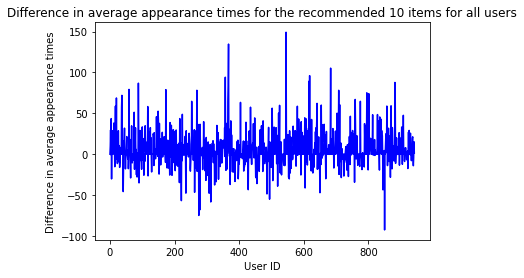

In [57]:
# draw the histogram for appearance using SVD and ApproSVD
x=range(0,n_users)
y1=compare_appearance['SVD']
y2=compare_appearance['ApproSVD']
plt.plot(x,y1-y2,'b')
plt.title('Difference in average appearance times for the recommended 10 items for all users')
plt.xlabel('User ID')
plt.ylabel('Difference in average appearance times')

Text(0, 0.5, 'Difference in average rating scores')

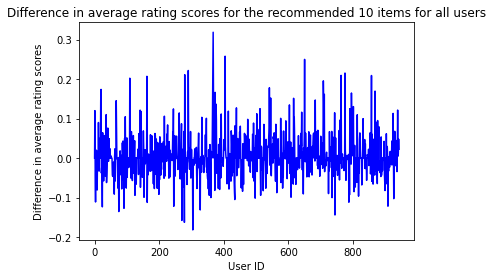

In [58]:
# draw the histogram for average using SVD and ApproSVD
x=range(0,n_users)
y1=compare_average['SVD']
y2=compare_average['ApproSVD']
plt.plot(x,y1-y2,'b')
plt.title('Difference in average rating scores for the recommended 10 items for all users')
plt.xlabel('User ID')
plt.ylabel('Difference in average rating scores')

In [95]:
a=np.array(y1)
b=np.array(y2)
print(gini(a), gini(b))

0.03155216513930439 0.03205091592083051


In [55]:
[t,p] =scipy.stats.ttest_ind(compare_average['SVD'],compare_average['ApproSVD'], alternative='greater')

In [63]:
[t,p] =scipy.stats.ttest_ind(compare_appearance['SVD'],compare_appearance['ApproSVD'], alternative='greater')

In [64]:
print (t,p)

2.1687588151977724 0.015112871456796436


# Hyperparameter 

In [97]:
def experiment_hyper(n1,n2,c1,c2,k):
  mat_all = ratings2matrix(ratings)
  mat_all_b1 = mat_all[:,:n1]
  mat_all_b2 = mat_all[:,n1:n1+n2]

  # colums sampling probabilities for B1
  nnz_b1 = np.count_nonzero(mat_all_b1)
  p1 = np.zeros(n1)
  for i in range(n1):
    p1[i] = np.count_nonzero(mat_all_b1[:, i]) / float(nnz_b1)

  # colums sampling probabilities for B2
  nnz_b2 = np.count_nonzero(mat_all_b2)
  p2 = np.zeros(n2)
  for i in range(n2):
    p2[i] = np.count_nonzero(mat_all_b2[:, i]) / float(nnz_b2)

  # calculate the approximation result for incremental Appro SVD
  mat_hk = incrementalApproSVD(mat_all_b1, mat_all_b2, c1, c2, k, p1, p2)
  mat_orig = mat_all[:, :n1+n2]
  mat_ApproSVD = np.dot(np.dot(mat_hk, mat_hk.T), mat_orig)

  # initialize the recommendation list
  recommend_ApproSVD = np.zeros((n_users,10))
  recommend_SVD = np.zeros((n_users,10))

  # calculate the recommended items for all the users
  for i in range(n_users):
    all_ratings = pd.DataFrame(columns=range(0,2))
    for j in range(0,n1+n2):
      if mat_all[i,j]!=0:
        all_ratings = all_ratings.append({0: mat_ApproSVD[i,j], 1: j},ignore_index=True) 
    all_ratings = all_ratings.sort_values(by=0,ascending=False)
    all_ratings[1] = all_ratings[1].astype(int)
    all_ratings = all_ratings.reset_index(drop=True)
    all_ratings = all_ratings.loc[0:9]
    recommend_ApproSVD[i,:] = all_ratings[1]

  # calculate the approximation result for normal SVD
  mat_u, vec_s, mat_vt = ln.svd(mat_all[:, :n1+n2], full_matrices=False)
  mat_SVD = np.dot(np.dot(mat_u[:, :k], np.diag(vec_s[:k])), mat_vt[:k, :])

  for i in range(n_users):
    all_ratings = pd.DataFrame(columns=range(0,2))
    for j in range(0,n1+n2):
      if mat_all[i,j]!=0:
        all_ratings = all_ratings.append({0: mat_SVD[i,j], 1: j},ignore_index=True) 
    all_ratings = all_ratings.sort_values(by=0,ascending=False)
    all_ratings[1] = all_ratings[1].astype(int)
    all_ratings = all_ratings.reset_index(drop=True)
    all_ratings = all_ratings.loc[0:9]
    recommend_SVD[i,:] = all_ratings[1]

  #intialize
  user_average_SVD = np.zeros(n_users)
  user_appearance_SVD = np.zeros(n_users)
  user_average_ApproSVD = np.zeros(n_users)
  user_appearance_ApproSVD = np.zeros(n_users)

  for i in range(n_users):

    user_average_SVD[i]=0
    for j in range(10):
      user_average_SVD[i]+= average.loc[recommend_SVD[i,j]]['rating']
    user_average_SVD[i] = user_average_SVD[i]/10

    user_appearance_SVD[i]=0
    for j in range(10):
      user_appearance_SVD[i]+= appearance.loc[recommend_SVD[i,j]]['user']
    user_appearance_SVD[i] = user_appearance_SVD[i]/10

    user_average_ApproSVD[i]=0
    for j in range(10):
      user_average_ApproSVD[i]+= average.loc[recommend_ApproSVD[i,j]]['rating']
    user_average_ApproSVD[i] = user_average_ApproSVD[i]/10

    user_appearance_ApproSVD[i]=0
    for j in range(10):
      user_appearance_ApproSVD[i]+= appearance.loc[recommend_ApproSVD[i,j]]['user']
    user_appearance_ApproSVD[i] = user_appearance_ApproSVD[i]/10

  # concat the average ratings for SVD and ApproSVD for comparation
  df_average_SVD = pd.DataFrame( user_average_SVD, columns=['SVD'] )
  df_average_ApproSVD = pd.DataFrame( user_average_ApproSVD, columns=['ApproSVD'] )
  compare_average = pd.concat( [df_average_SVD, df_average_ApproSVD], axis=1 )
  print(compare_average)

  df_appearance_SVD = pd.DataFrame( user_appearance_SVD, columns=['SVD'])
  df_appearance_ApproSVD = pd.DataFrame( user_appearance_ApproSVD, columns=['ApproSVD'])
  compare_appearance = pd.concat( [df_appearance_SVD, df_appearance_ApproSVD], axis=1 )
  print(compare_appearance)

  [t1,p1] =scipy.stats.ttest_ind(compare_average['SVD'],compare_average['ApproSVD'], alternative='greater')
  [t2,p2] =scipy.stats.ttest_ind(compare_appearance['SVD'],compare_appearance['ApproSVD'], alternative='greater')
  
  np1=np.array(compare_appearance['SVD'])
  np2=np.array(compare_appearance['ApproSVD'])
  gini1 = gini(np1)
  gini2 = gini(np2)
  
  return t1,p1,t2,p2,gini1,gini2

In [86]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [83]:
print(experiment_hyper(800,200,500,50,10))

          SVD  ApproSVD
0    4.121549  4.082844
1    3.966204  3.846025
2    3.678246  3.721306
3    3.430349  3.541526
4    4.004848  3.956622
..        ...       ...
938  3.636474  3.612869
939  4.024903  4.048203
940  3.739623  3.739623
941  4.079862  4.031068
942  4.099960  4.047501

[943 rows x 2 columns]
       SVD  ApproSVD
0    408.6     392.7
1    412.6     402.8
2    338.7     309.1
3    352.4     353.1
4    390.4     365.8
..     ...       ...
938  310.1     316.7
939  426.0     428.4
940  383.5     383.5
941  374.8     351.1
942  307.5     286.5

[943 rows x 2 columns]
(0.39539099908045416, 0.3462995573793696, 2.423005493037915, 0.007743200698737866)


In [96]:
print(experiment_hyper(700,300,500,50,10))

          SVD  ApproSVD
0    4.121549  4.139690
1    3.966204  3.982245
2    3.678246  3.721306
3    3.430349  3.363157
4    4.004848  3.960889
..        ...       ...
938  3.636474  3.601382
939  4.024903  4.030729
940  3.739623  3.739623
941  4.079862  4.085689
942  4.099960  4.053520

[943 rows x 2 columns]
       SVD  ApproSVD
0    408.6     398.6
1    412.6     354.0
2    338.7     309.1
3    352.4     307.5
4    390.4     370.3
..     ...       ...
938  310.1     319.8
939  426.0     409.1
940  383.5     383.5
941  374.8     357.9
942  307.5     314.3

[943 rows x 2 columns]
(0.2726852458779148, 0.39256253035399524, 2.1155666645300952, 0.01725629453602237)


In [98]:
np1=np.array(compare_appearance['SVD'])
np2=np.array(compare_appearance['ApproSVD'])
gini1 = gini(np1)
gini2 = gini(np2)
print(gini1,gini2)

0.0967305094191264 0.10622357551110938


In [99]:
print(experiment_hyper(900,100,400,40,10))

          SVD  ApproSVD
0    4.121549  4.159337
1    3.966204  3.956618
2    3.678246  3.721306
3    3.430349  3.541526
4    4.004848  4.003183
..        ...       ...
938  3.636474  3.621999
939  4.024903  4.058915
940  3.739623  3.739623
941  4.079862  4.029622
942  4.099960  3.871176

[943 rows x 2 columns]
       SVD  ApproSVD
0    408.6     384.6
1    412.6     374.1
2    338.7     309.1
3    352.4     353.1
4    390.4     338.6
..     ...       ...
938  310.1     297.6
939  426.0     397.4
940  383.5     383.5
941  374.8     352.5
942  307.5     288.0

[943 rows x 2 columns]
(0.5842666949882471, 0.27955542328034116, 1.6184679490555192, 0.05286458625459164, 0.0967305094191264, 0.10293091025349713)


In [100]:
print(experiment_hyper(900,100,600,60,10))

          SVD  ApproSVD
0    4.121549  4.121549
1    3.966204  3.846025
2    3.678246  3.721306
3    3.430349  3.541526
4    4.004848  4.033921
..        ...       ...
938  3.636474  3.601382
939  4.024903  4.020018
940  3.739623  3.739623
941  4.079862  4.040058
942  4.099960  3.981266

[943 rows x 2 columns]
       SVD  ApproSVD
0    408.6     408.6
1    412.6     402.8
2    338.7     309.1
3    352.4     353.1
4    390.4     360.6
..     ...       ...
938  310.1     319.8
939  426.0     440.1
940  383.5     383.5
941  374.8     373.2
942  307.5     299.6

[943 rows x 2 columns]
(0.6621586150324845, 0.2539752795719791, 1.6306600839687333, 0.051564605646906535, 0.0967305094191264, 0.10430999826126)


In [101]:
print(experiment_hyper(900,100,600,60,15))

          SVD  ApproSVD
0    4.121549  4.170032
1    4.132783  4.014134
2    3.678246  3.679805
3    3.434407  3.541526
4    3.932217  3.943739
..        ...       ...
938  3.514899  3.514899
939  4.101897  4.048203
940  3.725928  3.873060
941  4.192723  4.058806
942  4.203900  4.062058

[943 rows x 2 columns]
       SVD  ApproSVD
0    408.6     410.7
1    357.5     373.4
2    338.7     301.1
3    354.0     353.1
4    356.4     341.2
..     ...       ...
938  315.3     315.3
939  393.7     428.4
940  407.2     346.2
941  321.7     356.3
942  397.4     316.6

[943 rows x 2 columns]
(0.6925586665477874, 0.24433595475907255, 2.7393216192145027, 0.003107313909471562, 0.09983639275805346, 0.10862120199812592)


In [102]:
print(experiment_hyper(900,100,600,60,5))

          SVD  ApproSVD
0    4.173064  4.115196
1    3.789048  3.789048
2    3.635030  3.635030
3    3.541526  3.541526
4    4.110090  4.075806
..        ...       ...
938  3.636474  3.627195
939  3.935924  4.023754
940  3.781915  3.730546
941  3.945283  4.016290
942  4.108927  4.095104

[943 rows x 2 columns]
       SVD  ApproSVD
0    414.9     397.1
1    423.8     423.8
2    330.7     330.7
3    353.1     353.1
4    370.1     330.3
..     ...       ...
938  310.1     331.1
939  415.7     437.1
940  367.2     369.3
941  302.8     333.0
942  392.4     383.1

[943 rows x 2 columns]
(0.20769736454595147, 0.4177438617273768, 1.538398458632274, 0.06205957129532849, 0.08720393231483804, 0.09208844999414612)
